In [1]:
pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob
from collections import defaultdict

dataset_path = "/kaggle/input/my-dataset"

years = defaultdict(list)

for i in ['2018', '2019', '2020', '2021']:
    year_path = os.path.join(dataset_path, i)

    tiff_files = glob.glob(os.path.join(year_path, '**', '*.tif'), recursive=True)
    tiff_files += glob.glob(os.path.join(year_path, '**', '*.tiff'), recursive=True)
    years[i].extend(tiff_files)

for i in sorted(years.keys()):
    print(f"{i}: {len(years[i])} TIFF files")


2018: 3773 TIFF files
2019: 1425 TIFF files
2020: 4292 TIFF files
2021: 4117 TIFF files


In [3]:
import pandas as pd
import os

info = []

for yr, paths in years.items():
    for path in paths:
        fire_id = os.path.basename(os.path.dirname(path))  
        date_path = os.path.splitext(os.path.basename(path))[0]  
        
        info.append({
            'yr': yr,
            'fire_id': fire_id,
            'date': date_path,
            'path': path
        })

df = pd.DataFrame(info)
df['date'] = pd.to_datetime(df['date'], errors='coerce')  

df_2018 = df[df['yr'] == '2018'].reset_index(drop=True)
df_2019 = df[df['yr'] == '2019'].reset_index(drop=True)
df_2020 = df[df['yr'] == '2020'].reset_index(drop=True)
df_2021 = df[df['yr'] == '2021'].reset_index(drop=True)

print("df of 2018 shape :", df_2018.shape)
print("df of 2019 shape:", df_2019.shape)
print("df of 2020 shape:", df_2020.shape)
print("df of 2021 shape:", df_2021.shape)


df of 2018 shape : (3773, 4)
df of 2019 shape: (1425, 4)
df of 2020 shape: (4292, 4)
df of 2021 shape: (4117, 4)


In [4]:
id = df_2018['fire_id'].value_counts()
print(id)

fire_id
fire_21889697    94
fire_21889719    67
fire_21889754    56
fire_21997775    52
fire_21890524    52
                 ..
fire_21615469    11
fire_21458801    11
fire_22343689    11
fire_21890063    11
fire_21997854    10
Name: count, Length: 176, dtype: int64


In [5]:
import rasterio
from collections import Counter

def get_shape_band(df_year, year_label):
    print(f"\nFor {year_label}:")
    shapes = []
    bands = []
    
    for path in df_year['path']:
        try:
            with rasterio.open(path) as src:
                shape = (src.height, src.width)
                b_count = src.count
                shapes.append(shape)
                bands.append(b_count)
        except Exception as e:
            print(f"{path} not found: {e}")
            continue

    shape_num = Counter(shapes)
    band_num = Counter(bands)

    print(f"\nImage shapes in {year_label}:")
    for s, c in shape_num.items():
        print(f"Shape {s}: {c} images")

    print(f"\nBand counts in {year_label}:")
    for b, c in band_num.items():
        print(f" {b} Bands: {c} images")

get_shape_band(df_2018, "2018")
get_shape_band(df_2019, "2019")
get_shape_band(df_2020, "2020")
get_shape_band(df_2021, "2021")



For 2018:

Image shapes in 2018:
Shape (304, 215): 16 images
Shape (300, 230): 12 images
Shape (329, 283): 19 images
Shape (304, 222): 19 images
Shape (347, 307): 18 images
Shape (326, 254): 21 images
Shape (299, 236): 20 images
Shape (331, 264): 23 images
Shape (354, 307): 11 images
Shape (345, 291): 23 images
Shape (314, 235): 37 images
Shape (303, 217): 17 images
Shape (346, 286): 27 images
Shape (304, 207): 33 images
Shape (306, 249): 24 images
Shape (317, 247): 13 images
Shape (302, 217): 20 images
Shape (315, 247): 28 images
Shape (319, 256): 30 images
Shape (348, 298): 21 images
Shape (330, 270): 22 images
Shape (329, 248): 22 images
Shape (305, 247): 43 images
Shape (331, 270): 14 images
Shape (338, 292): 25 images
Shape (303, 216): 15 images
Shape (298, 221): 78 images
Shape (342, 286): 57 images
Shape (344, 286): 24 images
Shape (338, 297): 14 images
Shape (329, 271): 29 images
Shape (306, 241): 18 images
Shape (306, 217): 17 images
Shape (325, 278): 12 images
Shape (313, 23

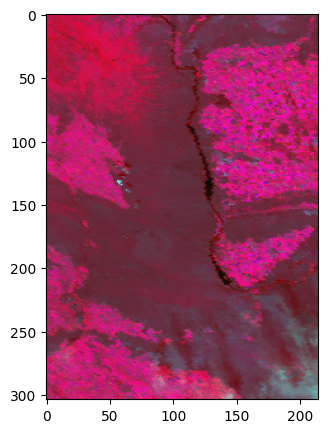

In [6]:
import rasterio
import matplotlib.pyplot as plot
import numpy as np

def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-5)

def img_plot(path):
    with rasterio.open(path) as src:
        img = src.read()
        img = np.nan_to_num(img, nan=0.0)
        
        red = normalize(img[3]) 
        gre = normalize(img[2]) 
        blue = normalize(img[1])  
        rgb = np.stack([red, gre, blue], axis=-1)

        plot.figure(figsize=(15,5))
        plot.imshow(rgb)
        plot.show()

path = df_2018.iloc[0]['path']
img_plot(path)


**Data cleaning and preprocessing**

In [7]:
import os
import zipfile
import rasterio
import numpy as np
from tqdm import tqdm

def resize(img, target_shape=(351, 303)):
    bands, h, w = img.shape
    th, tw = target_shape

    top_crop = max((h - th) // 2, 0)
    left_crop = max((w - tw) // 2, 0)
    img = img[:, top_crop:top_crop+th, left_crop:left_crop+tw]

    pad_h = max(th - img.shape[1], 0)
    pad_w = max(tw - img.shape[2], 0)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    return np.pad(img, ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')


In [50]:
def clean_and_preprocess(df_year, year_label, zip_path, target_shape=(351, 303), output_dir="preprocessed_images"):
    output_path = os.path.join(output_dir, year_label)
    os.makedirs(output_path, exist_ok=True)

    valid_count, skipped_count = 0, 0

    with zipfile.ZipFile(zip_path, 'r') as z:
        for _, row in tqdm(df_year.iterrows(), total=len(df_year), desc=f"Processing {year_label}"):
            fire_id = row['fire_id']
            date_str = row['date'].strftime('%Y-%m-%d')
            tiff_path = row['path']

            try:
                with z.open(tiff_path) as f:
                    with rasterio.open(f) as src:
                        if src.count != 23:
                            skipped_count += 1
                            continue

                        img = src.read()
                        nan_ratio = np.isnan(img).sum() / img.size

                        if nan_ratio > 0.5:
                            skipped_count += 1
                            continue

                        img = np.nan_to_num(img, nan=0.0)
                        img = np.clip(img, a_min=0, a_max=None)

                        if np.all(img == 0):
                            skipped_count += 1
                            continue

                        aligned = resize(img, target_shape)

                        fire_folder = os.path.join(output_path, fire_id)
                        os.makedirs(fire_folder, exist_ok=True)
                        save_path = os.path.join(fire_folder, f"{date_str}.npy")
                        np.save(save_path, aligned)
                        valid_count += 1

            except Exception:
                skipped_count += 1
                continue

    print(f"\n {year_label} done — saved: {valid_count}, skipped: {skipped_count}")


In [51]:
clean_and_preprocess(df_2018, "2018", zip_path)
clean_and_preprocess(df_2019, "2019", zip_path)
clean_and_preprocess(df_2020, "2020", zip_path)
clean_and_preprocess(df_2021, "2021", zip_path)

Processing 2018: 100%|█████████████████████████████████████████████████████████████| 3773/3773 [22:45<00:00,  2.76it/s]



 2018 done — saved: 3773, skipped: 0


Processing 2019: 100%|█████████████████████████████████████████████████████████████| 1425/1425 [09:14<00:00,  2.57it/s]



 2019 done — saved: 1425, skipped: 0


Processing 2020: 100%|█████████████████████████████████████████████████████████████| 4292/4292 [28:24<00:00,  2.52it/s]



 2020 done — saved: 4292, skipped: 0


Processing 2021: 100%|█████████████████████████████████████████████████████████████| 4117/4117 [25:56<00:00,  2.64it/s]



 2021 done — saved: 4117, skipped: 0


**Stats of processed data**

In [8]:
import os
import numpy as np

def processed_stats(path):
    img = np.load(path)
    
    stats = {
        "shape": img.shape,
        "min": float(np.min(img)),
        "max": float(np.max(img)),
        "mean": float(np.mean(img)),
        "std": float(np.std(img)),
        "zero_ratio": float(np.sum(img == 0) / img.size)
    }
    return stats

main = "/kaggle/input/preprocessed-images/2018/2018"
fires = os.listdir(main)[:3]  

for i in fires:
    fire_path = os.path.join(main, i)
    fire_files = sorted(os.listdir(fire_path))[:2] 
    
    for f in fire_files:
        path = os.path.join(fire_path, f)
        print(f"\n{i} | {f}")
        
        stats = processed_stats(path)
        for k, v in stats.items():
            print(f" {k}: {v}")
    


fire_21889953 | 2018-07-15.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 9562.0
 mean: 368.2386169433594
 std: 1031.176025390625
 zero_ratio: 0.5135461520882671

fire_21889953 | 2018-07-16.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 9562.0
 mean: 370.411865234375
 std: 1028.7315673828125
 zero_ratio: 0.5158420338503564

fire_22257911 | 2018-10-03.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 15126.0
 mean: 301.17156982421875
 std: 975.934326171875
 zero_ratio: 0.46250325515643353

fire_22257911 | 2018-10-04.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 14880.0
 mean: 522.73193359375
 std: 1628.913818359375
 zero_ratio: 0.4644238485535659

fire_21688910 | 2018-04-23.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 8319.0
 mean: 512.1036376953125
 std: 979.3441162109375
 zero_ratio: 0.2396612756779208

fire_21688910 | 2018-04-24.npy
 shape: (23, 351, 303)
 min: 0.0
 max: 7330.0
 mean: 491.2017517089844
 std: 949.1402587890625
 zero_ratio: 0.24063179264786383


**Visualizing the processed images**


2018, random fire choosen: fire_21890013


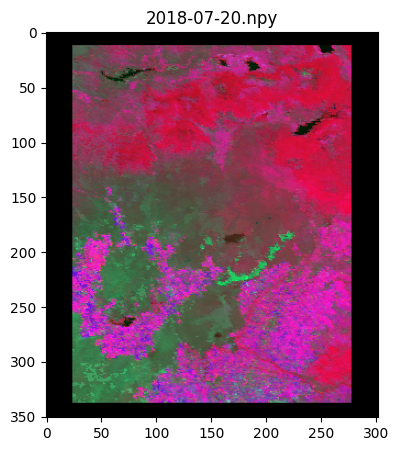

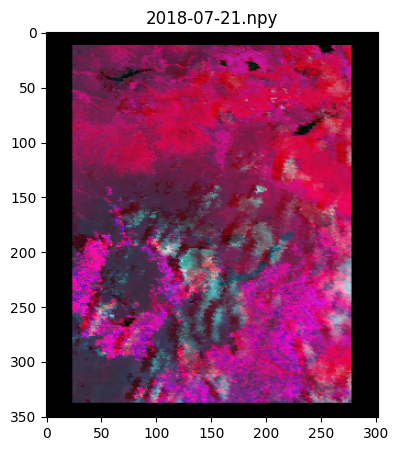

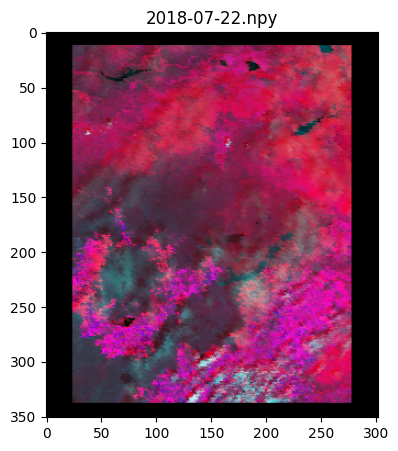


2019, random fire choosen: fire_23300839


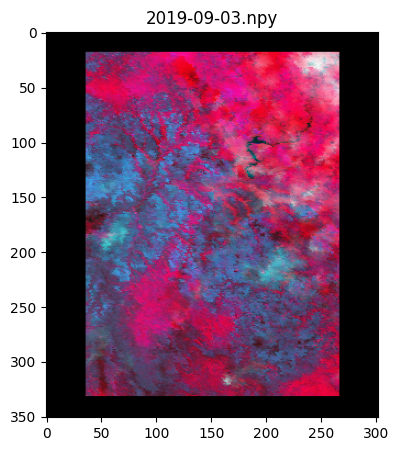

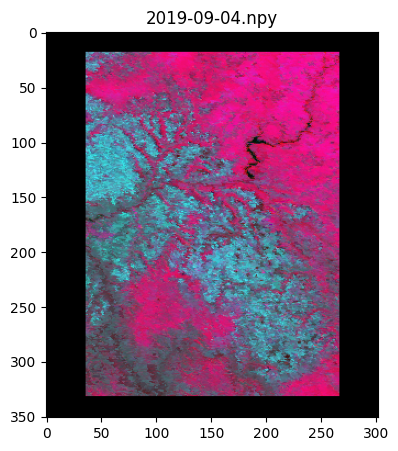

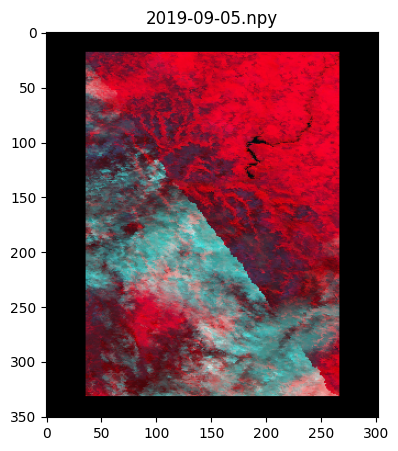


2020, random fire choosen: fire_24191360


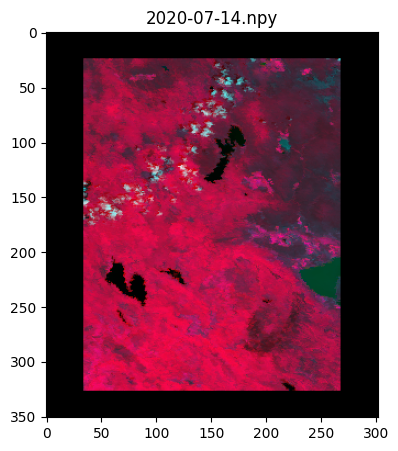

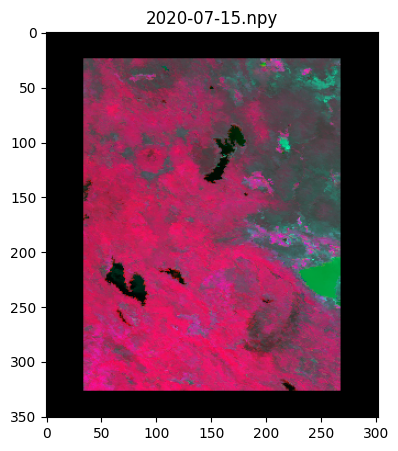

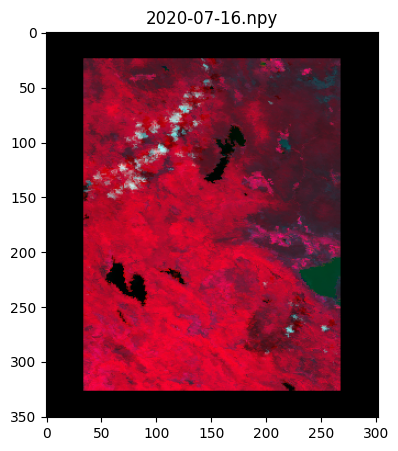


2021, random fire choosen: fire_25295816


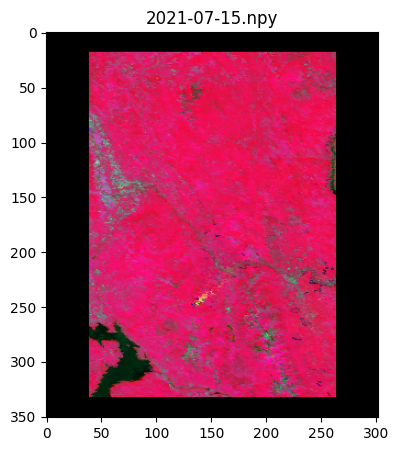

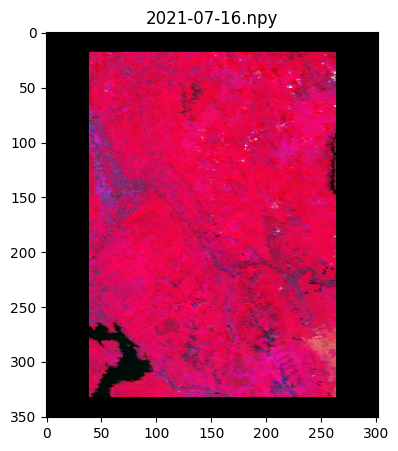

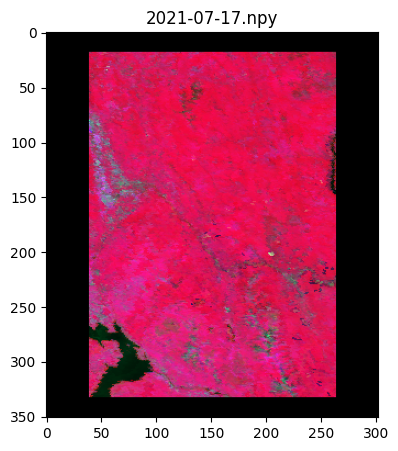

In [9]:
import random
import os
import numpy as np
import matplotlib.pyplot as plot

def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-5)

def plot_yrs(path):
    img = np.load(path)
    
    red = normalize(img[3])  
    gre = normalize(img[2])  
    blue = normalize(img[1]) 
    rgb = np.stack([red, gre, blue], axis=-1)
    
    plot.figure(figsize=(10, 5))
    plot.imshow(rgb)
    plot.title(f"{os.path.basename(path)}")
    plot.show()

def years_files(year):
   
    year_files = f"/kaggle/input/preprocessed-images/{year}/{year}"
    
    if not os.path.exists(year_files):
        print(f"no folder {year} at {year_files}")
        return

    folders = os.listdir(year_files)
    
    if not folders:
        print(f"No fire data in {year}")
        return

    random_fire = random.choice(folders)
    
    print(f"\n{year}, random fire choosen: {random_fire}")

    fire_path = os.path.join(year_files, random_fire)
    
    imgs = sorted([f for f in os.listdir(fire_path) if f.endswith('.npy')])
    if not imgs:
        print(f"No files found in {fire_path}")
        return

    for i in imgs[:3]:
        plot_yrs(os.path.join(fire_path, i))

for year in ["2018","2019", "2020", "2021"]:
    years_files(year)


**Checking images per year**

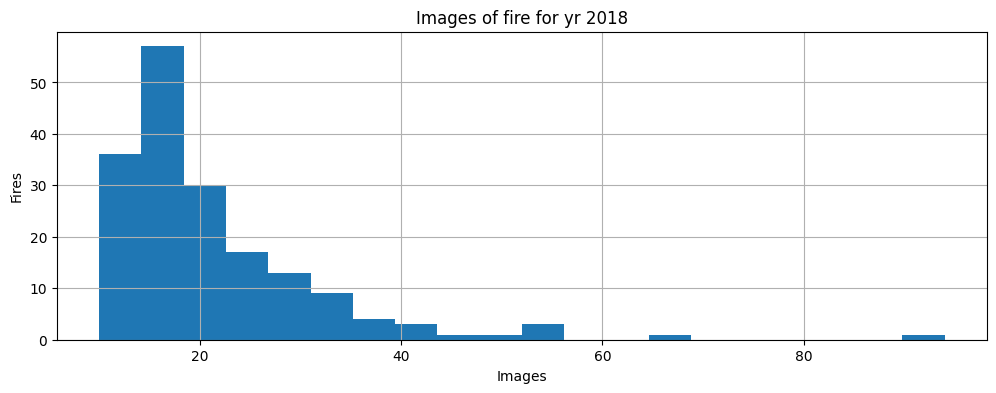

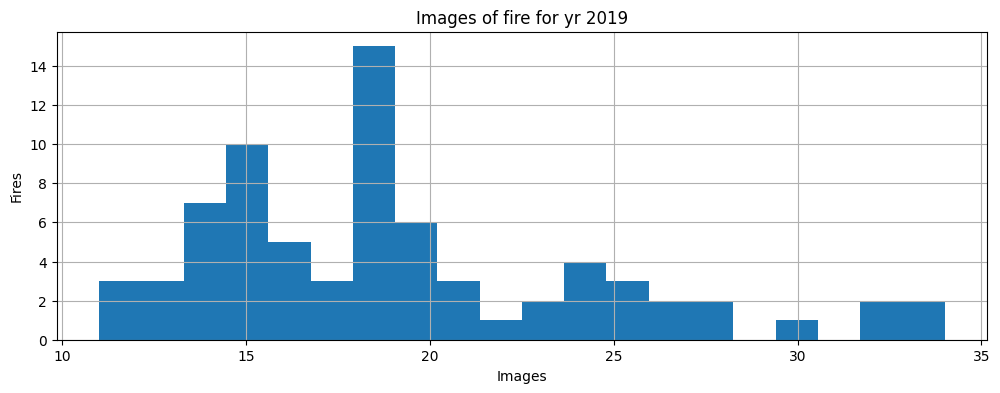

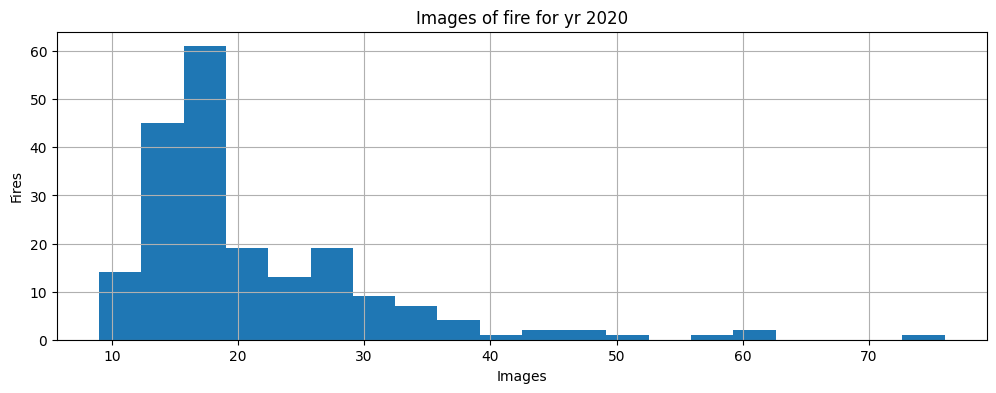

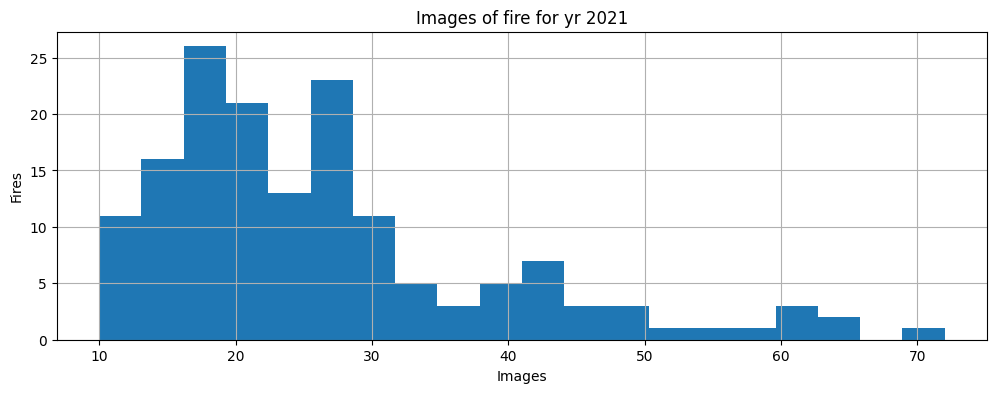

In [10]:
import matplotlib.pyplot as plot

def plotting_gr(df_year, year_label):
    
    numbers = df_year['fire_id'].value_counts()

    plot.figure(figsize=(12, 4))
    
    numbers.hist(bins=20)
    
    plot.title(f"Images of fire for yr {year_label}")
    plot.xlabel("Images")
    plot.ylabel("Fires")
    plot.grid(True)
    plot.show()
    
plotting_gr(df_2018, "2018")
plotting_gr(df_2019, "2019")
plotting_gr(df_2020, "2020")
plotting_gr(df_2021, "2021")


**Combining all df** 

In [11]:
df_all = pd.concat([df_2018, df_2019, df_2020, df_2021], ignore_index=True)

print(f" total fire files: {df_all['fire_id'].nunique()} | total images: {len(df_all)}")


 total fire files: 607 | total images: 13607


**Splitting data to train, val and test set**

In [13]:
from sklearn.model_selection import train_test_split

def data_split(df, test_size=0.15, val_size=0.15, seed=42):
    
    fire_uni = df['fire_id'].unique()
    
    train_ids, temp_ids = train_test_split(fire_uni, test_size=test_size + val_size, random_state=seed)
    
    val_ids, test_ids = train_test_split(temp_ids, test_size=test_size / (test_size + val_size), random_state=seed)
    
    return train_ids, val_ids, test_ids

train_ids, val_ids, test_ids = data_split(df_all)
print(f"Train set: {len(train_ids)}")
print(f"Val set: {len(val_ids)}") 
print (f"Test set: {len(test_ids)}")


Train set: 424
Val set: 91
Test set: 92


**Normalizing train set**

In [60]:
import numpy as np
import os
from tqdm import tqdm

def min_max(base_folder, fire_uni):
    mins = np.full(23, np.inf)
    maxs = np.full(23, -np.inf)

    for year in ['2018', '2019', '2020', '2021']:
        for fire_id in fire_uni:
            fire_path = os.path.join(base_folder, year, fire_id)
            if not os.path.isdir(fire_path):
                continue
            for file in os.listdir(fire_path):
                if file.endswith('.npy'):
                    img = np.load(os.path.join(fire_path, file))
                    band_min = img.reshape(23, -1).min(axis=1)
                    band_max = img.reshape(23, -1).max(axis=1)
                    mins = np.minimum(mins, band_min)
                    maxs = np.maximum(maxs, band_max)

    return mins, maxs

base_folder = "preprocessed-images"
min_vals, max_vals = min_max(base_folder, train_ids)

np.save("min_vals_global.npy", min_vals)
np.save("max_vals_global.npy", max_vals)


**Exploratory data analysis**

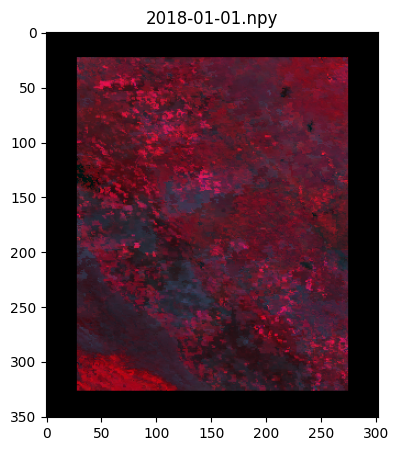

In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random

min_vals = np.load("/kaggle/input/min-vals-global/min_vals_global.npy")
max_vals = np.load("/kaggle/input/max-vals-global/max_vals_global.npy")

def normalize(img, min_vals, max_vals):
    norm = (img - min_vals[:, None, None]) / (max_vals[:, None, None] - min_vals[:, None, None] + 1e-6)
    
    return np.clip(norm, 0, 1)

def plotting_imgs(img_path):
    img = np.load(img_path)
    img_norm = normalize(img, min_vals, max_vals)

    rgb = np.stack([img_norm[3], img_norm[2],  img_norm[1]], axis=-1)

    plt.figure(figsize=(10, 5))
    plt.imshow(rgb)
    plt.title(f"{os.path.basename(img_path)}")
    plt.show()

random_path = "/kaggle/input/preprocessed-images/2018/2018/fire_21458798/2018-01-01.npy"
plotting_imgs(random_path)


**Modelling**

**Model: ConvNet-based encoder-decoder using U-Net**

In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from glob import glob
from torch.utils.data import DataLoader

class fire_dataset(Dataset):
    def __init__(self, main, fire_uni, transform=None):
        self.samples = []
        self.transform = transform

        for yr in ['2018', '2019', '2020', '2021']:
            for id in fire_uni:
                fire_path = os.path.join(main, yr, yr, id)
                if not os.path.isdir(fire_path):
                    continue

                file = sorted(glob(os.path.join(fire_path, '*.npy')))
                for i in range(len(file) - 1):
                    self.samples.append((file[i], file[i+1]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_path, target_path = self.samples[idx]
        input_img = np.load(input_path).astype(np.float32)
        target_img = np.load(target_path).astype(np.float32)

        input_img /= 1e4
        target_img /= 1e4

        input_tensor = torch.from_numpy(input_img)
        target_tensor = torch.from_numpy(target_img)

        if self.transform:
            input_tensor = self.transform(input_tensor)
            target_tensor = self.transform(target_tensor)

        return input_tensor, target_tensor

train_dataset = fire_dataset("/kaggle/input/preprocessed-images", train_ids)
val_dataset   = fire_dataset("/kaggle/input/preprocessed-images", val_ids)
test_dataset = fire_dataset("/kaggle/input/preprocessed-images", test_ids)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=8, num_workers=4, pin_memory=True)
test_loader   = DataLoader(test_dataset, batch_size=8, num_workers=4, pin_memory=True)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet_model(nn.Module):
    def __init__(self, in_channels=23, out_channels=23):
        super(UNet_model, self).__init__()

        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = self.conv_block(256, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)  
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)  
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)   
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):

        e1 = self.enc1(x)             
        e2 = self.enc2(self.pool(e1))    
        e3 = self.enc3(self.pool(e2))    
        
        b = self.bottleneck(self.pool(e3)) 
        
        d3 = self.up3(b)                    

        e3_cropped = F.adaptive_avg_pool2d(e3, d3.shape[2:])
        d3 = self.dec3(torch.cat([d3, e3_cropped], dim=1))
        
        d2 = self.up2(d3)                  
        e2_cropped = F.adaptive_avg_pool2d(e2, d2.shape[2:])
        d2 = self.dec2(torch.cat([d2, e2_cropped], dim=1))
        
        d1 = self.up1(d2)                  
        e1_cropped = F.adaptive_avg_pool2d(e1, d1.shape[2:])
        d1 = self.dec1(torch.cat([d1, e1_cropped], dim=1))
        
        out = self.final(d1)

        out = F.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_model(in_channels=23, out_channels=23).to(device)
print(model)


UNet_model(
  (enc1): Sequential(
    (0): Conv2d(23, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddin

In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = UNet_model(in_channels=23, out_channels=23).to(device)

cri = nn.MSELoss()
opti = optim.Adam(model.parameters(), lr=1e-4)

num_epoch = 10

for epoch in range(num_epoch):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epoch} [Train]", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)

        opti.zero_grad()
        outputs = model(inputs)
        loss = cri(outputs, targets)
        loss.backward()
        opti.step()

        train_loss += loss.item()
    total_tr_loss = train_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epoch} [Val]", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = cri(outputs, targets)
            val_loss += loss.item()
    total_val_loss = val_loss / len(val_loader)
    
    print(f"\nEpoch {epoch+1}/{num_epoch}")
    print(f"Train Loss: {total_tr_loss:.4f}")
    print(f"Val Loss: {total_val_loss:.4f}")


cuda


Epoch 1/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 0.0037
Val Loss: 0.0031


Epoch 2/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 0.0028
Val Loss: 0.0030


Epoch 3/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.0028
Val Loss: 0.0030


Epoch 4/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.0027
Val Loss: 0.0029


Epoch 5/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.0027
Val Loss: 0.0029


Epoch 6/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.0027
Val Loss: 0.0029


Epoch 7/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 7/10
Train Loss: 0.0026
Val Loss: 0.0028


Epoch 8/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 0.0026
Val Loss: 0.0028


Epoch 9/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 9/10
Train Loss: 0.0026
Val Loss: 0.0028


Epoch 10/10 [Train]:   0%|          | 0/1117 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/261 [00:00<?, ?it/s]


Epoch 10/10
Train Loss: 0.0026
Val Loss: 0.0029


In [21]:
import torch

torch.save(model.state_dict(), "model_weights.pth")

torch.save(model, "model_save.pth")

print("Model and weights saved")

Model and weights saved


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = UNet_model(in_channels=23, out_channels=23)  

model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))
model.to(device)
model.eval()
print("Model loaded")

cri = nn.MSELoss()

test_loss = 0.0
predict = []
target = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Evaluating test set", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = cri(outputs, targets)
        test_loss += loss.item()
        
        predict.append(outputs.cpu().numpy().flatten())
        target.append(targets.cpu().numpy().flatten())

total_te_loss = test_loss / len(test_loader)

predict = np.concatenate(predict)
target = np.concatenate(target)

r2 = r2_score(target, predict)
mse = mean_squared_error(target, predict)
mae = mean_absolute_error(target, predict)

print(f"\nTest Loss : {total_te_loss:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


cuda
Model loaded


<ipython-input-22-c9e8204e489c>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))

Evaluating test set:   0%|          | 0/248 [00:00<?, ?it/s]

**Training a subset of data to verify results**

In [17]:
import random
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm 
from torch.utils.data import Subset, DataLoader

ratio = 0.1

train_sub_size = int(len(train_dataset) * ratio)
tr_ind = random.sample(range(len(train_dataset)), train_sub_size)
train_sub_ds = Subset(train_dataset, tr_ind)
train_sub_dl = DataLoader(train_sub_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

val_sub_size = int(len(val_dataset) * ratio)
val_ind = random.sample(range(len(val_dataset)), val_sub_size)
val_sub_ds = Subset(val_dataset, val_ind)
val_sub_dl = DataLoader(val_sub_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = UNet_model(in_channels=23, out_channels=23).to(device)
cri = nn.MSELoss()
opti = optim.Adam(model.parameters(), lr=1e-4)
num_epoch = 10

for epoch in range(num_epoch):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_sub_dl, desc=f"Epoch {epoch+1}/{num_epoch} [Train]", leave=False):
        inputs = inputs.to(device)
        targets = targets.to(device)

        opti.zero_grad()
        outputs = model(inputs)
        loss = cri(outputs, targets)
        loss.backward()
        opti.step()

        train_loss += loss.item()

    tr_loss_total = train_loss / len(train_sub_dl)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_sub_dl, desc=f"Epoch {epoch+1}/{num_epoch} [Val]", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = cri(outputs, targets)
            val_loss += loss.item()

    val_loss_total = val_loss / len(val_sub_dl)
    
    print(f"\nEpoch {epoch+1}/{num_epoch}")
    print(f"Train Loss: {tr_loss_total:.4f} ")
    print(f"Val Loss: {val_loss_total:.4f}")

cuda


Epoch 1/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 0.0088 
Val Loss: 0.0045


Epoch 2/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 0.0039 
Val Loss: 0.0037


Epoch 3/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.0034 
Val Loss: 0.0033


Epoch 4/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.0033 
Val Loss: 0.0033


Epoch 5/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.0032 
Val Loss: 0.0032


Epoch 6/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.0031 
Val Loss: 0.0031


Epoch 7/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 7/10
Train Loss: 0.0031 
Val Loss: 0.0031


Epoch 8/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 0.0031 
Val Loss: 0.0030


Epoch 9/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 9/10
Train Loss: 0.0031 
Val Loss: 0.0030


Epoch 10/10 [Train]:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/26 [00:00<?, ?it/s]


Epoch 10/10
Train Loss: 0.0030 
Val Loss: 0.0030


In [19]:
import torch
import random
import numpy as np
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNet_model(in_channels=23, out_channels=23)
model.load_state_dict(torch.load("/kaggle/working/model_wt.pth", map_location=device))
model.to(device)
model.eval()
print("Model loaded ")

ratio = 0.1
test_sub_size = int(len(test_dataset) * ratio)
test_ind = random.sample(range(len(test_dataset)), test_sub_size)
test_sub_ds = Subset(test_dataset, test_ind)
test_sub_dl = DataLoader(test_sub_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

predict = []
target = []

with torch.no_grad():
    for inputs, targets in tqdm(test_sub_dl, desc="Evaluating test subset", leave = False):
        inputs = inputs.to(device)
        
        targets = targets.to(device)
        outputs = model(inputs)
        
        predict.append(outputs.cpu().numpy().flatten())
        target.append(targets.cpu().numpy().flatten())

predict = np.concatenate(predict)
target = np.concatenate(target)

r2 = r2_score(target, predict)
mse = mean_squared_error(target, predict)
mae = mean_absolute_error(target, predict)

print("Metrics to evaluate model:")
print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

Using device: cuda
Model loaded 


<ipython-input-19-dadc18cefddf>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model_wt.pth", map_location=device))


Evaluating test subset:   0%|          | 0/25 [00:00<?, ?it/s]

Metrics to evaluate model:
R2 Score: 0.8232
MSE: 0.0028
MAE: 0.0164


**References**

1. https://tqdm.github.io/
2. https://www.geeksforgeeks.org/u-net-architecture-explained/
3. https://towardsdatascience.com/understanding-u-net-61276b10f360/
4. https://www.analyticsvidhya.com/blog/2022/10/image-segmentation-with-u-net/
5. https://medium.com/@alejandro.itoaramendia/decoding-the-u-net-a-complete-guide-810b1c6d56d8
6. https://medium.com/@nghihuynh_37300/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
   